In [113]:
import pickle
import gensim
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

import constants, transactions

%matplotlib inline

In [3]:
tle = transactions.TransLogExtractor(constants.RAW_DATA_DIR, constants.FEAT_DATA_DIR)

In [4]:
prior_orders = tle.get_orders_items('prior')

In [6]:
train_orders = tle.get_orders_items('train')

In [30]:
products = tle.get_items('products')

In [7]:
prior_orders['product_id'] = prior_orders['product_id'].astype(str)

In [8]:
train_orders['product_id'] = train_orders['product_id'].astype(str)

In [11]:
prior_products = prior_orders.groupby('order_id').apply(lambda grp: grp['product_id'].tolist())

In [12]:
train_products = train_orders.groupby('order_id').apply(lambda grp: grp['product_id'].tolist())

In [13]:
sentences = prior_products.append(train_products)

In [14]:
longest = np.max(sentences.apply(len))

In [17]:
sentences = sentences.values

## gensim word2vec
- 输入文本
    - 每行是一个句子（list of str）

In [19]:
%%time
model = gensim.models.Word2Vec(sentences, size=100, window=longest, min_count=2, workers=4)

CPU times: user 7min 40s, sys: 3.91 s, total: 7min 44s
Wall time: 2min 19s


In [20]:
vocab = list(model.wv.vocab.keys())

In [21]:
pca = PCA(n_components=2)
pca.fit(model.wv.syn0)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [28]:
def get_batch(vocab, model, n_batches=3):
    output = list()
    for i in range(0, n_batches):
        rand_int = np.random.randint(len(vocab), size=1)[0] # 从vocabulary中选择一个词
        suggestions = model.most_similar(positive=[vocab[rand_int]], topn=5)# 依照word2vec模型选出最相似的5个
        suggest = list()
        for i in suggestions:
            suggest.append(i[0])
        output += suggest # 相似词列表
        output.append(vocab[rand_int]) # 中心词
    return output

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    """From Tensorflow's tutorial."""
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
#     plt.savefig(filename)
    plt.show()

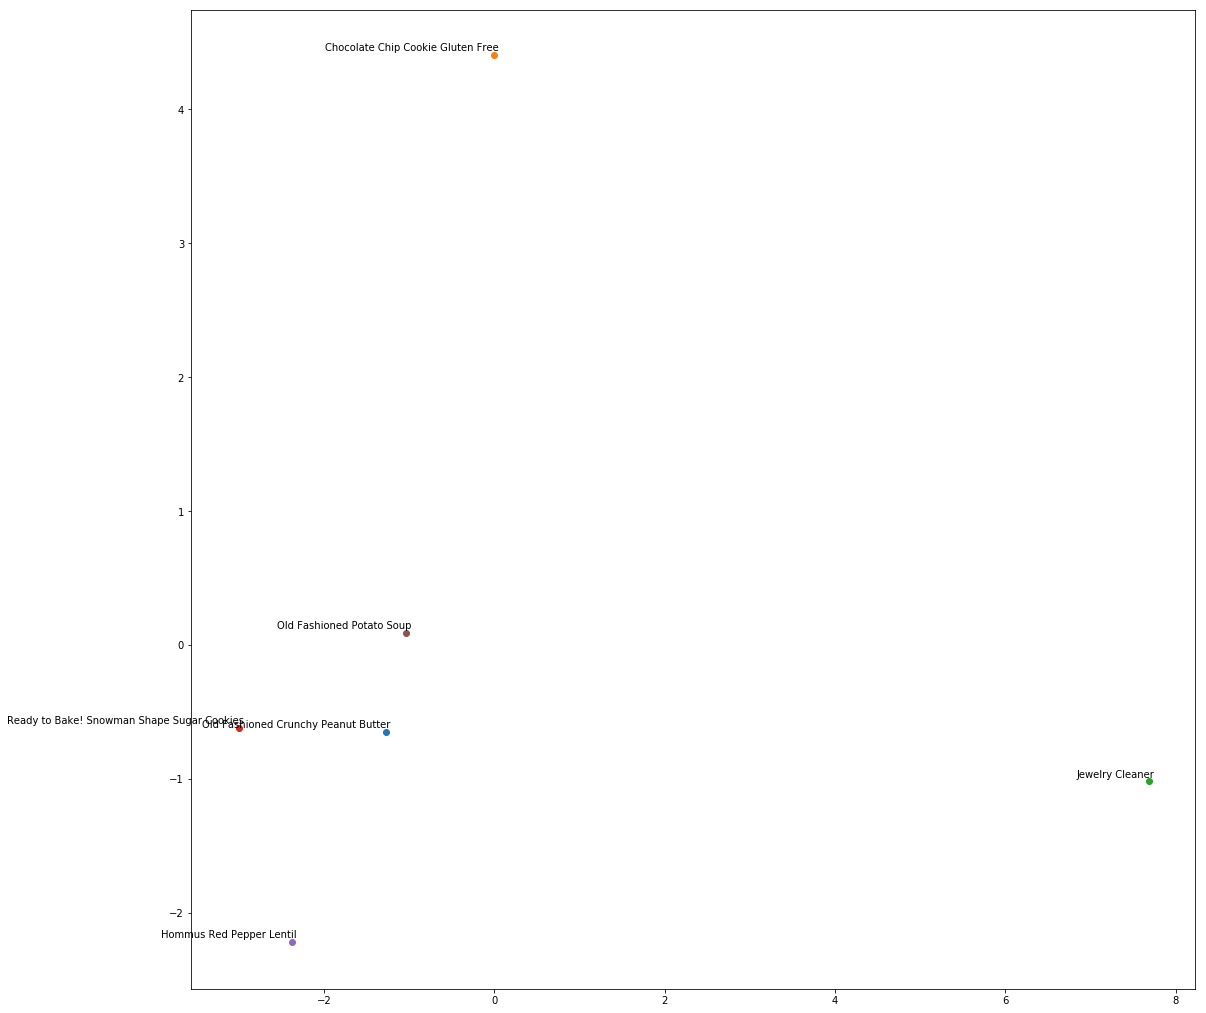

In [41]:
embeds = []
labels = []
for item in get_batch(vocab, model, n_batches=1):
    embeds.append(model[item])
    labels.append(products.loc[int(item)]['product_name']) 
embeds = np.array(embeds)
embeds = pca.fit_transform(embeds)
plot_with_labels(embeds, labels)

In [44]:
model.save(constants.W2V_DIR + "product2vec.model")

In [48]:
?? model.score

In [74]:
pca = PCA(n_components=25)
pca.fit(model.wv.syn0)

PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [100]:
compressed = pd.DataFrame(pca.transform(model[vocab]), columns=['w2v_dim_%d'%i for i in range(25)])

In [102]:
compressed['product_id'] = vocab

In [103]:
compressed['product_id'] = compressed['product_id'].astype(int)

In [106]:
compressed = pd.merge(products[['product_id']], compressed, on=['product_id'], how='left')

In [110]:
for col in compressed.columns:
    compressed[col] = compressed[col].fillna(compressed[col].mean())

In [114]:
with open(constants.FEAT_DATA_DIR + 'p_w2v_feat.pkl', 'wb') as f:
    pickle.dump(compressed, f, pickle.HIGHEST_PROTOCOL)